In [73]:
from src.data.get_dataset import get_merged_datasets
dataframe = get_merged_datasets()

dataframe.shape

(3104, 204)

In [74]:
numeric_cols = dataframe.select_dtypes(include=['number']).columns.difference(['year']).tolist() #we don't want year to be a feature in our prediction model
#we want to limit our feature set to columns without any data leaks, since in real prediction we wouldn't know those values.
data_leak_list = ["co2", "ghg", "greenhouse_gas",  "change"]
possible_data_leak_list = ["nitrous_oxide", "methane", "ch4", "n2o"]
to_exclude = data_leak_list + possible_data_leak_list

def is_data_leak(s, to_exclude):
    for data_leak in to_exclude:
        if data_leak in s:
            return True

    return False

feature_list = []
for x in numeric_cols:
    is_leak = is_data_leak(x, data_leak_list)
    if not is_leak:
        feature_list.append(x)


print(feature_list)

['agricultural_land_area_in_hectares', 'biofuel_cons_per_capita', 'biofuel_consumption', 'biofuel_elec_per_capita', 'biofuel_electricity', 'biofuel_share_elec', 'biofuel_share_energy', 'carbon_intensity_elec', 'coal_cons_per_capita', 'coal_consumption', 'coal_elec_per_capita', 'coal_electricity', 'coal_prod_per_capita', 'coal_production', 'coal_share_elec', 'coal_share_energy', 'cropland_area_in_hectares', 'electricity_demand', 'electricity_generation', 'electricity_share_energy', 'energy_per_capita', 'energy_per_gdp', 'forest_land_area_in_hectares', 'fossil_elec_per_capita', 'fossil_electricity', 'fossil_energy_per_capita', 'fossil_fuel_consumption', 'fossil_share_elec', 'fossil_share_energy', 'gas_consumption', 'gas_elec_per_capita', 'gas_electricity', 'gas_energy_per_capita', 'gas_prod_per_capita', 'gas_production', 'gas_share_elec', 'gas_share_energy', 'gdp', 'hydro_consumption', 'hydro_elec_per_capita', 'hydro_electricity', 'hydro_energy_per_capita', 'hydro_share_elec', 'hydro_sha

In [75]:
#checking correlations between various features and co2 data
dataframe[feature_list + ['co2']].corr()['co2'].sort_values(ascending=False) #Reduced feature list to 97, need to check if any of these are unrelated. 

co2                           1.000000
fossil_fuel_consumption       0.992006
fossil_electricity            0.990423
primary_energy_consumption    0.987311
electricity_generation        0.979749
                                ...   
hydro_share_elec             -0.112958
renewables_share_elec        -0.115668
oil_share_elec               -0.146162
nuclear_share_energy         -0.164512
oil_share_energy             -0.173952
Name: co2, Length: 102, dtype: float64

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

data_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ('std_scalar', StandardScaler())])
# test if I can hand-pick a few features avoiding most of the repeats.
hand_picked_feature_list = ['fossil_electricity','coal_electricity', 'oil_electricity', 'hydro_electricity', 'wind_electricity', 'primary_energy_consumption', 'electricity_demand', 'gdp', 'low_carbon_electricity', 'renewables_electricity', 'agricultural_land_area_in_hectares', 'cropland_area_in_hectares', 'population', 'nuclear_electricity', 'forest_land_area_in_hectares', 'median_age', 'solar_electricity']

X = dataframe[feature_list]
y = dataframe['co2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [77]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

[LinearRegression(),
 Ridge(random_state=42),
 Lasso(random_state=42),
 DecisionTreeRegressor(random_state=42),
 RandomForestRegressor(random_state=42),
 SGDRegressor(random_state=42)]

## Training Model for features with no data leaks

In [78]:
X_train_no_data_leaks = data_pipeline.fit_transform(X_train)
X_test_no_data_leaks = data_pipeline.transform(X_test)
linear_model = LinearRegression()
ridge_model = Ridge(random_state=42)
lasso_model = Lasso(random_state=42)
sgd_model = SGDRegressor(random_state=42)
decision_tree_model = DecisionTreeRegressor(random_state=42)
random_forest_model = RandomForestRegressor(random_state=42)

models_no_data_leaks = [linear_model, ridge_model, lasso_model, decision_tree_model, random_forest_model, sgd_model]
[x.fit(X_train_no_data_leaks, y_train) for x in models_no_data_leaks ] #train features with data leak features removed

[LinearRegression(),
 Ridge(random_state=42),
 Lasso(random_state=42),
 DecisionTreeRegressor(random_state=42),
 RandomForestRegressor(random_state=42),
 SGDRegressor(random_state=42)]

## Training on hand-picked features

In [94]:
X_train_hand_picked = data_pipeline.fit_transform(X_train[hand_picked_feature_list])
X_test_hand_picked = data_pipeline.transform(X_test[hand_picked_feature_list])
linear_model = LinearRegression()
ridge_model = Ridge(random_state=42)
lasso_model = Lasso(random_state=42)
sgd_model = SGDRegressor(random_state=42)
decision_tree_model = DecisionTreeRegressor(random_state=42)
random_forest_model = RandomForestRegressor(random_state=42)

model_hand_picked = [linear_model, ridge_model, lasso_model, decision_tree_model, random_forest_model, sgd_model]
[x.fit(X_train_hand_picked, y_train) for x in model_hand_picked ] #train hand-picked features for models.

[LinearRegression(),
 Ridge(random_state=42),
 Lasso(random_state=42),
 DecisionTreeRegressor(random_state=42),
 RandomForestRegressor(random_state=42),
 SGDRegressor(random_state=42)]

In [95]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

def adjusted_r2(r2_score, sample_size, num_features):
    return 1-(1-r2_score)*(sample_size-1)/(sample_size-num_features-1)

## Checking scores for models with data leak features removed.

In [98]:
training_predictions = [m.predict(X_train_no_data_leaks) for m in models_no_data_leaks]
mean_sq_errors = [mean_squared_error(y_train, y) for y in training_predictions]
r2_scores = [r2_score(y_train, y) for y in training_predictions]
adj_r2_scores = [adjusted_r2(score, len(X_train_no_data_leaks),len(X.columns)) for score in r2_scores]
mean_absolute_pcent_errors = [mean_absolute_percentage_error(y_train, y) for y in training_predictions]
print("Train data scores")
[print(f" {model.__class__.__name__}: Mean Squared Error: {mean_sq_errors[i]}, R2_score {r2_scores[i]}, Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Percentage Error: {mean_absolute_pcent_errors[i]*100}%") for i, model in enumerate(models_all)]

Train data scores
 LinearRegression: Mean Squared Error: 289.5085709265024, R2_score 0.9994327369831895, Adjusted R2 score: 0.9993827501938958, Mean absolute Percentage Error: 154.86914585539674%
 Ridge: Mean Squared Error: 325.0258479308347, R2_score 0.9993631444400813, Adjusted R2 score: 0.9993070252083656, Mean absolute Percentage Error: 141.5141591515493%
 Lasso: Mean Squared Error: 478.24819754432156, R2_score 0.9990629206090341, Adjusted R2 score: 0.9989803458797119, Mean absolute Percentage Error: 133.03416468595586%
 DecisionTreeRegressor: Mean Squared Error: 3.723102590841213e-36, R2_score 1.0, Adjusted R2 score: 1.0, Mean absolute Percentage Error: 1.927283154112025e-17%
 RandomForestRegressor: Mean Squared Error: 229.00656752222608, R2_score 0.999551284592555, Adjusted R2 score: 0.9995117441292072, Mean absolute Percentage Error: 3.0447826494203847%
 SGDRegressor: Mean Squared Error: 786.8921595717871, R2_score 0.9984581637119939, Adjusted R2 score: 0.9983222982609246, Mean 

[None, None, None, None, None, None]

In [99]:
predictions = [m.predict(X_test_no_data_leaks) for m in models_no_data_leaks]
mean_sq_errors = [mean_squared_error(y_test, y_) for y_ in predictions]
r2_scores = [r2_score(y_test, y_) for y_ in predictions]
adj_r2_scores = [adjusted_r2(score, len(X_test_no_data_leaks),len(X.columns)) for score in r2_scores]
mean_absolute_pcent_errors = [mean_absolute_percentage_error(y_test, y) for y in predictions]
print("Test data scores")
[print(f" {model.__class__.__name__}: Mean Squared Error: {mean_sq_errors[i]}, R2_score {r2_scores[i]}, Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Percentage Error: {mean_absolute_pcent_errors[i]*100}%") for i, model in enumerate(models_no_data_leaks)]

Test data scores
 LinearRegression: Mean Squared Error: 376.05361547816034, R2_score 0.9996468962750119, Adjusted R2 score: 0.9994775076145761, Mean absolute Percentage Error: 175.58496269521552%
 Ridge: Mean Squared Error: 400.79043696049706, R2_score 0.9996236690982204, Adjusted R2 score: 0.9994431380450994, Mean absolute Percentage Error: 147.47200766960106%
 Lasso: Mean Squared Error: 510.1154761928786, R2_score 0.9995210159737761, Adjusted R2 score: 0.9992912408203847, Mean absolute Percentage Error: 144.5616106173071%
 DecisionTreeRegressor: Mean Squared Error: 3028.1515466312417, R2_score 0.9971566512142575, Adjusted R2 score: 0.9957926581213357, Mean absolute Percentage Error: 10.380844166959752%
 RandomForestRegressor: Mean Squared Error: 819.9185094290365, R2_score 0.999230119674563, Adjusted R2 score: 0.9988607976091386, Mean absolute Percentage Error: 7.83990669180519%
 SGDRegressor: Mean Squared Error: 834.8276557141554, R2_score 0.9992161204072432, Adjusted R2 score: 0.99

[None, None, None, None, None, None]

## Checking scores for hand-picked features

In [100]:
training_predictions = [m.predict(X_train_hand_picked) for m in model_hand_picked]
mean_sq_errors = [mean_squared_error(y_train, y) for y in training_predictions]
r2_scores = [r2_score(y_train, y) for y in training_predictions]
adj_r2_scores = [adjusted_r2(score, len(X_train_hand_picked),len(X.columns)) for score in r2_scores]
mean_absolute_pcent_errors = [mean_absolute_percentage_error(y_train, y) for y in training_predictions]
print("Train data scores")
[print(f" {model.__class__.__name__}: Mean Squared Error: {mean_sq_errors[i]}, R2_score {r2_scores[i]}, Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Percentage Error: {mean_absolute_pcent_errors[i]*100}%") for i, model in enumerate(model_hand_picked)]

Train data scores
 LinearRegression: Mean Squared Error: 879.5319944053741, R2_score 0.9982766452442804, Adjusted R2 score: 0.998124784522711, Mean absolute Percentage Error: 69.0896663602801%
 Ridge: Mean Squared Error: 903.1736830267689, R2_score 0.9982303217258887, Adjusted R2 score: 0.9980743790108091, Mean absolute Percentage Error: 63.3136380127831%
 Lasso: Mean Squared Error: 1146.5368255085075, R2_score 0.9977534760492895, Adjusted R2 score: 0.9975555140527561, Mean absolute Percentage Error: 65.63382422717916%
 DecisionTreeRegressor: Mean Squared Error: 3.723102590841213e-36, R2_score 1.0, Adjusted R2 score: 1.0, Mean absolute Percentage Error: 1.927283154112025e-17%
 RandomForestRegressor: Mean Squared Error: 291.06302180723304, R2_score 0.9994296911925475, Adjusted R2 score: 0.9993794360104792, Mean absolute Percentage Error: 3.0802275071050036%
 SGDRegressor: Mean Squared Error: 2525.3251214613565, R2_score 0.9950518786292124, Adjusted R2 score: 0.9946158539051755, Mean abs

[None, None, None, None, None, None]

In [101]:
predictions = [m.predict(X_test_hand_picked) for m in model_hand_picked]
mean_sq_errors = [mean_squared_error(y_test, y_) for y_ in predictions]
r2_scores = [r2_score(y_test, y_) for y_ in predictions]
adj_r2_scores = [adjusted_r2(score, len(X_test_hand_picked),len(X.columns)) for score in r2_scores]
mean_absolute_pcent_errors = [mean_absolute_percentage_error(y_test, y) for y in predictions]
print("Test data scores")
[print(f" {model.__class__.__name__}: Mean Squared Error: {mean_sq_errors[i]}, R2_score {r2_scores[i]}, Adjusted R2 score: {adj_r2_scores[i]}, Mean absolute Percentage Error: {mean_absolute_pcent_errors[i]*100}%") for i, model in enumerate(model_hand_picked)]

Test data scores
 LinearRegression: Mean Squared Error: 897.770488440689, R2_score 0.9991570188648506, Adjusted R2 score: 0.9987526293465571, Mean absolute Percentage Error: 70.44665233491584%
 Ridge: Mean Squared Error: 914.3866742239034, R2_score 0.9991414167356498, Adjusted R2 score: 0.99872954266373, Mean absolute Percentage Error: 64.43855119704645%
 Lasso: Mean Squared Error: 1232.557560248675, R2_score 0.9988426632589806, Adjusted R2 score: 0.9982874730801146, Mean absolute Percentage Error: 68.38473450335937%
 DecisionTreeRegressor: Mean Squared Error: 2832.231697384863, R2_score 0.9973406144198234, Adjusted R2 score: 0.9960648709792136, Mean absolute Percentage Error: 9.82589012310158%
 RandomForestRegressor: Mean Squared Error: 1316.1881935835838, R2_score 0.9987641364560509, Adjusted R2 score: 0.998171275901555, Mean absolute Percentage Error: 8.184174432435306%
 SGDRegressor: Mean Squared Error: 3637.796512189277, R2_score 0.9965842118082832, Adjusted R2 score: 0.9949456117

[None, None, None, None, None, None]

In [105]:
#Linear paradoxically is our best bet after the clean-up. 
random_forest_preds = predictions[4]

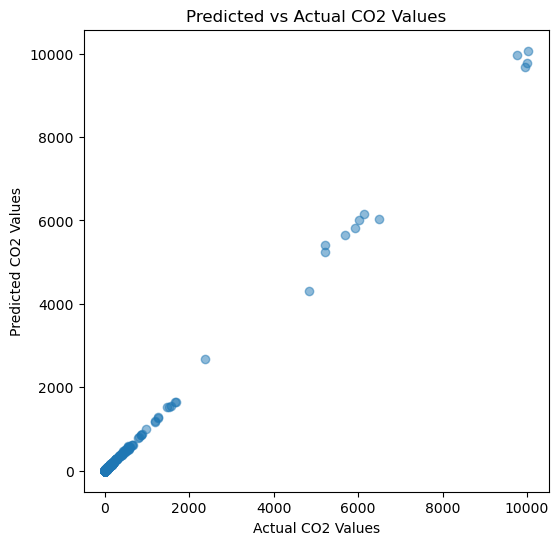

In [106]:
#Seems like Lasso performs the best which is to be expected.

import matplotlib.pyplot as plt

# Plotting predicted vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, random_forest_preds, alpha=0.5)
plt.xlabel('Actual CO2 Values')
plt.ylabel('Predicted CO2 Values')
plt.title('Predicted vs Actual CO2 Values')
plt.show()

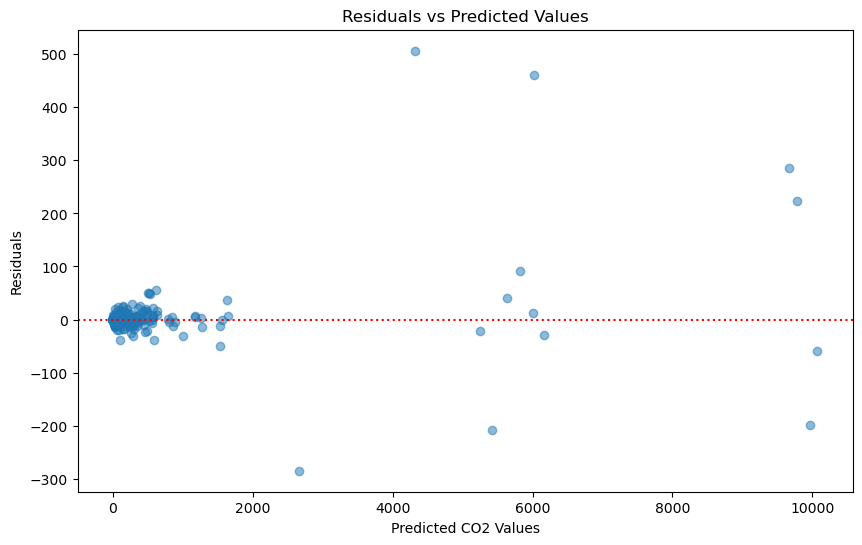

In [107]:
# Assuming you have your actual and predicted values as follows:
actual_values = y_test
predicted_values = random_forest_preds

# Calculate residuals
residuals = actual_values - predicted_values

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(predicted_values, residuals, alpha=0.5)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted CO2 Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle=':')  # Adds a horizontal line at zero
plt.show()